In [1]:
import numpy as np
import cv2
import os
from torch.utils.data import Dataset
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import sys
from torch.nn.functional import one_hot

sys.path.append('../src')

from utils import visualise_mask

In [2]:
category_names = ['Backgroud', 'scratch', 'word_error']
dataset_path = '../data/seg_data/all'
def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir, mode = 'train', transform = None):
        super().__init__()
        self.mode = mode
        self.transform = transform
        self.coco = COCO(data_dir)
        self.img_ids = list(self.coco.getImgIds())
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=self.img_ids[index])
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        if (self.mode in ('train', 'val')):
            ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
            anns = self.coco.loadAnns(ann_ids)

            # Load the categories in a variable
            cat_ids = self.coco.getCatIds()
            cats = self.coco.loadCats(cat_ids)

            # masks : size가 (height x width)인 2D
            # 각각의 pixel 값에는 "category id + 1" 할당
            # Background = 0
            masks = np.zeros((image_infos["height"], image_infos["width"]))
            # Unknown = 1, General trash = 2, ... , Cigarette = 11
            for i in range(len(anns)):
                className = get_classname(anns[i]['category_id'], cats)
                # if className == 'word_error':
                #     print(index)
                #     print(className)
                pixel_value = category_names.index(className)
                masks = np.maximum(self.coco.annToMask(anns[i])*pixel_value, masks)
            masks = masks.astype(np.float32)
                        
            
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images, mask=masks)
                images = transformed["image"]
                masks = transformed["mask"]
                
            return images, masks
        
        if self.mode == 'test':
            # transform -> albumentations 라이브러리 활용
            if self.transform is not None:
                transformed = self.transform(image=images)
                images = transformed["image"]
                test = thisdict = {
                                      "brand": 1,
                                      "model": 0,
                                      "year": 1
                                    }
                image_infos = str(image_infos)
                print(image_infos)
            return images, test
    
    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

In [3]:
trans = A.Compose([
    # A.Resize(512, 512),
    ToTensorV2()
])

In [4]:
dset = CustomDataLoader('../data/seg_data/crop_bm-1.json', transform=trans)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [5]:
img, mask = dset[20]

In [6]:
one_hot_mask = one_hot(mask.long(), num_classes=3)

In [8]:
one_hot_mask.shape

torch.Size([1900, 1900, 3])

In [41]:
masked_img = visualise_mask((img.permute(1,2,0).numpy() * 255).astype(np.uint8), one_hot_mask.numpy().astype(np.uint8))

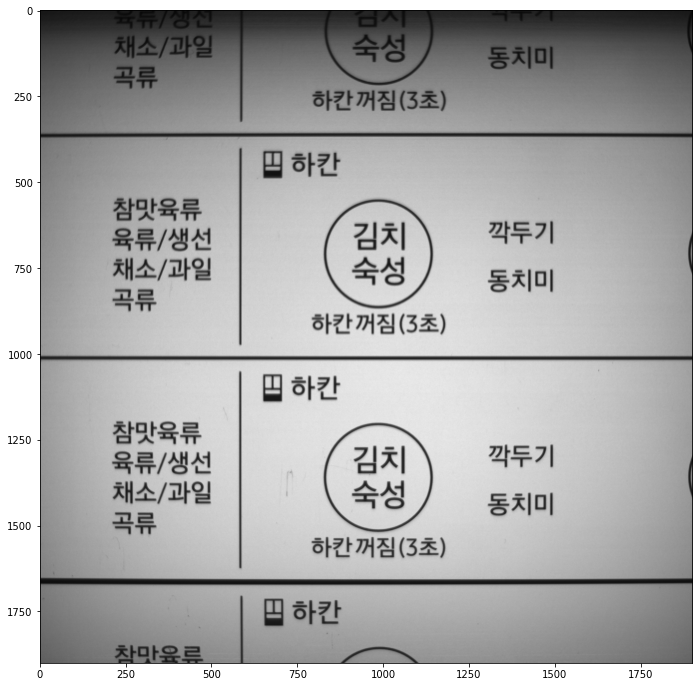

In [43]:
plt.figure(figsize=(12, 12))
plt.imshow((img.permute(1,2,0).numpy() * 255).astype(np.uint8))

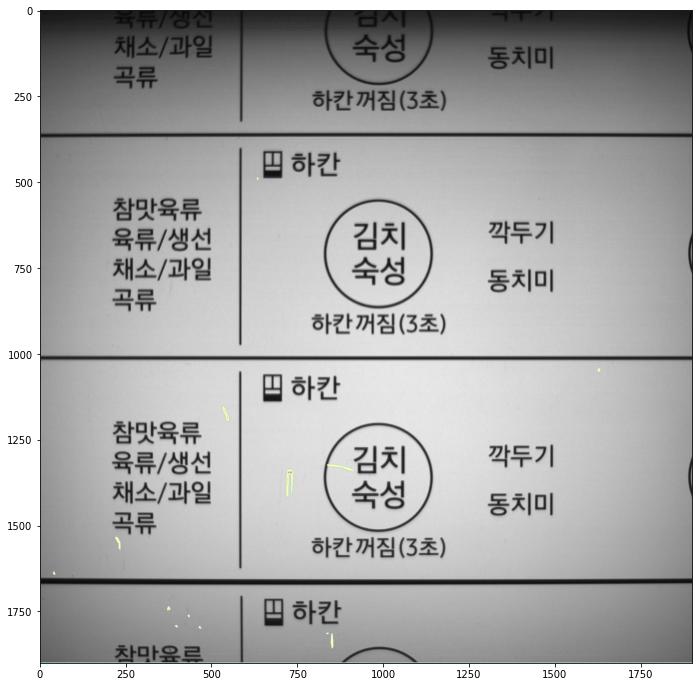

In [42]:
plt.figure(figsize=(12, 12))
plt.imshow(masked_img)

image shape: [3, 1900, 1900]
mask shape:  [1900, 1900]
Unique values, category of transformed mask : 
 [{0, 'Backgroud'}, {1, 'scratch'}, {2, 'word_error'}]


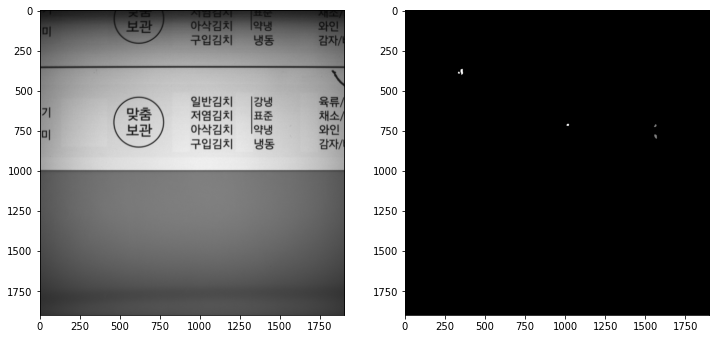

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

print('image shape:', list(img.shape))
print('mask shape: ', list(mask.shape))

print('Unique values, category of transformed mask : \n', [{int(i),category_names[int(i)]} for i in list(np.unique(mask))])

ax1.imshow(img.permute(1, 2, 0))
ax1.grid(False)

ax2.imshow(mask, cmap='gray')
ax2.grid(False)

plt.show()